In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cv2 as cv
import seaborn as sns

from IPython.display import HTML

np.set_printoptions(suppress=True)

In [3]:
# Read in fatality data
data = pd.read_csv('./../assets/data/us_deaths.csv', delimiter=";")
data['deaths_avg']

0         0.00
1         0.00
2         0.00
3         0.00
4         0.00
         ...  
1153    333.64
1154    289.82
1155    282.61
1156    257.28
1157    255.30
Name: deaths_avg, Length: 1158, dtype: float64

In [4]:
def plot_t(data):
    """Helper function for plotting timeseries data."""
    t = np.linspace(1, len(data), len(data))
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(t, data)
    return t

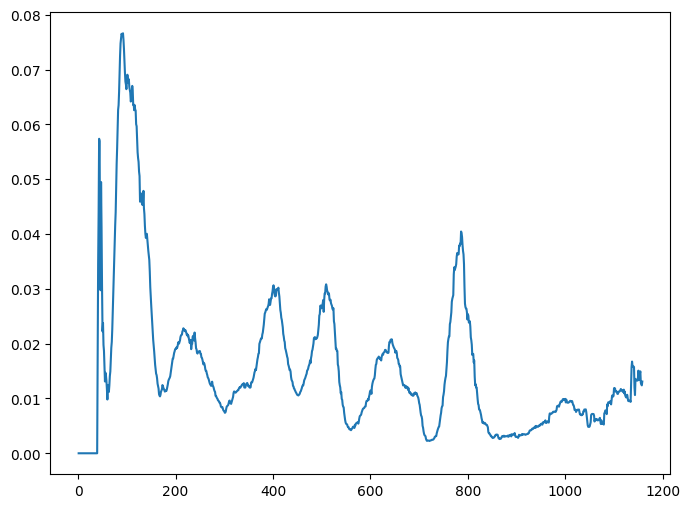

In [5]:
fatality_rate = data.deaths_avg / data.cases_avg

t = plot_t(fatality_rate)

In [6]:
def sample_snapshot(n_samples=200, n_channels=4, rng=None):
    """ 
    Sample a snapshot of spike counts per speaker channels.

    Parameters:
    -----------
    n_samples   : int
        Number of total samples to distribute to each channel.
    n_channels  : int
        Number of speaker channels.

    Returns:
    --------
    snapshot    : np.array
        An array of distributed spike count per speaker channel.
    """
    
    if rng is None:
        seed = np.random.randint(10000)
        RNG = np.random.default_rng()

    # Generate a bin of speaker channel indices for a given sample count
    samples = np.uint16(RNG.uniform(0, n_channels, size=n_samples))

    # Accumulate them as snapshot
    snapshot = np.zeros(n_channels) if n_samples == 0 else np.bincount(samples)

    # Ensure that every channel is covered in the snapshot via zero-padding and reshuffling
    if snapshot.shape[0] < n_channels:
        snapshot = np.concatenate([snapshot, np.zeros(n_channels - snapshot.shape[0], dtype=np.uint16)])
        snapshot = np.random.permutation(snapshot)
    return snapshot

def sample_snapshot_fast(n_samples=200, n_channels=4, rng=None):
    """ 
    Sample a snapshot of spike counts per speaker channels.

    Parameters:
    -----------
    n_samples   : int
        Number of total samples to distribute to each channel.
    n_channels  : int
        Number of speaker channels.

    Returns:
    --------
    snapshot    : np.array
        An array of distributed spike count per speaker channel.
    """
    
    if rng is None:
        seed = np.random.randint(10000)
        RNG = np.random.default_rng()

    return RNG.multinomial(n_samples, pvals=np.ones(n_channels) / n_channels)

In [7]:
snapshot = sample_snapshot_fast(n_samples=200, n_channels=128)
snapshot

array([1, 2, 3, 2, 2, 1, 0, 1, 1, 4, 4, 3, 0, 0, 3, 2, 1, 1, 1, 1, 3, 0,
       5, 1, 1, 1, 0, 1, 0, 1, 1, 2, 0, 2, 3, 1, 2, 0, 1, 1, 2, 2, 3, 1,
       3, 2, 2, 2, 1, 0, 0, 3, 5, 2, 1, 0, 2, 5, 0, 2, 1, 4, 3, 2, 1, 0,
       2, 0, 2, 1, 1, 2, 2, 2, 0, 0, 3, 1, 4, 2, 0, 2, 1, 2, 1, 1, 2, 1,
       2, 2, 0, 0, 3, 0, 1, 1, 3, 4, 0, 4, 2, 3, 2, 1, 1, 1, 1, 0, 3, 2,
       0, 1, 2, 1, 2, 2, 2, 1, 2, 0, 0, 3, 0, 4, 1, 0, 2, 1], dtype=int64)

In [8]:
def sample_sequence(n_samples, n_channels=4):
    """ 
    Generate a sequence of spike counts distributed to each sonification stream.

    Parameters:
    -----------
    n_samples : np.array
        An array of total sample to distribute to each channel.
    n_channels  : int
        Number of speaker channels.  
    
    Returns:
    --------
    sequence : np.2darray
        A sequence of spike count arrays.
    """
    
    sequence = np.array([sample_snapshot(s, n_channels) for s in n_samples], dtype=np.uint16)
    return sequence

In [9]:
deaths = data.deaths_avg.astype(np.uint16)
seq = sample_sequence(deaths, n_channels=128)
seq

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 4, ..., 6, 2, 1],
       [2, 4, 2, ..., 2, 2, 4],
       [4, 6, 3, ..., 3, 4, 1]], dtype=uint16)

In [10]:
def sample_daily_deaths(x, y, n_deaths, rng=None):
    """ Add a nice docstring. """
    if rng is None:
        rng = np.random.default_rng()

    if x % y != 0:
        raise ValueError("Aspect ratio must be integer.")
    
    data = np.ones(x*y, dtype=np.uint8)
    samples = rng.permutation(x*y)[:n_deaths]
    np.put(data, samples, 0)
    return data.reshape((y, x))

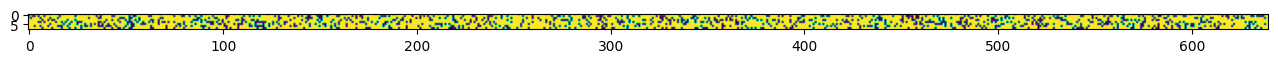

In [11]:
x, y = (640, 8)
n_deaths = int(data.deaths_avg[585])

sample = sample_daily_deaths(x, y, n_deaths)

f, ax = plt.subplots(figsize=(16, 12))
ax.imshow(sample)

In [12]:
n_deaths

1284

In [13]:
flattened = sample.flatten()
flattened[640:648]

array([0, 1, 0, 0, 1, 0, 1, 1], dtype=uint8)

### Variants

In [14]:
us_data = pd.read_csv('../Assets/data/us_variants.csv', delimiter=';').to_numpy()

In [15]:
weeks_dt = np.unique(us_data[:,0])
weeks = np.linspace(0, len(weeks_dt)-1, len(weeks_dt), dtype=np.int16)
num_weeks = len(weeks)

variants = np.unique(us_data[:,1])
num_variants = len(variants)

In [16]:
proportions = np.zeros((num_variants, num_weeks), dtype=np.float32)
proportion_count = np.zeros((num_variants, num_weeks), dtype=np.float32)

In [17]:
for v in range(num_variants):
    for w in range(num_weeks):
        reports = us_data[(us_data[:,0] == weeks_dt[w]) & (us_data[:,1] == variants[v])][:,2]
        if len(reports) > 0:
            proportions[v, w] = np.min(reports)

In [18]:
proportions_total = np.sum(proportions, axis=0)
proportions = proportions / proportions_total

In [19]:
np.sum(proportions[:,32])

1.0

In [20]:
RNG = np.random.default_rng(2024)

variant_samples = RNG.multinomial(n_deaths, pvals=proportions[:,30])
variant_id = np.where(variant_samples != 0)
variant_id

(array([ 1, 12, 13, 32], dtype=int64),)

In [21]:
variant_samples

array([   0,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0, 1276,    5,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    1,
          0,    0], dtype=int64)

In [22]:
flattened_spikes = (sample.flatten() + 1) % 2
flattened_spikes.shape

(5120,)

In [23]:
sample_id = np.where((sample.flatten() + 1) % 2 != 0)
s = sample_id[0].shape[0]

sample_counts = variant_samples[variant_id]
sample_counts

array([   2, 1276,    5,    1], dtype=int64)

In [24]:
variant_spikes = RNG.choice(variant_id[0], s, p=sample_counts / s)
variant_spikes

flattened_spikes[flattened_spikes != 0] = variant_spikes
flattened_spikes[0:30]

array([12, 12,  0,  0,  0,  0,  0,  0,  0, 12,  0, 12,  0,  0,  0, 12, 12,
        0, 12,  0,  0,  0,  0,  0, 12, 12,  0, 12,  0, 12], dtype=uint8)

In [25]:
variant_ids = flattened_spikes.reshape((y, x))
variant_ids[0:8, 0:8]

array([[12, 12,  0,  0,  0,  0,  0,  0],
       [12,  0, 12, 12,  0, 12,  0,  0],
       [ 0, 12,  0,  0,  0,  0, 12,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 12],
       [ 0,  0,  0,  0,  0, 12, 12,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 12,  0,  0, 12,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 12]], dtype=uint8)

In [26]:
variant_spikes = variant_ids.copy()
variant_spikes[np.where(variant_spikes != 0)] = 1
variant_spikes[0:8, 0:8]

array([[1, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1]], dtype=uint8)

In [27]:
# For OpenCV only
cv.imshow("", sample * 255)
cv.waitKey(0)

-1

### Audio

In [28]:
def generate_chains(data, invert=False):
    y, x = data.shape
    n_channels = int(x / y)
    n_buffers = y * y

    if invert is True:
        spike_chains = (np.array(np.split(data, n_channels, axis=1)).reshape((n_channels, n_buffers)) + 1) % 2
    else:
        spike_chains = np.array(np.split(data, n_channels, axis=1)).reshape((n_channels, n_buffers))
    return spike_chains

In [29]:
spike_chains = generate_chains(variant_spikes)
spike_chains[0,:]

array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
      dtype=uint8)

In [30]:
variant_chains = generate_chains(variant_ids)
variant_chains[0, :]

array([12, 12,  0,  0,  0,  0,  0,  0, 12,  0, 12, 12,  0, 12,  0,  0,  0,
       12,  0,  0,  0,  0, 12,  0,  0,  0,  0,  0,  0,  0,  0, 12,  0,  0,
        0,  0,  0, 12, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       12,  0,  0, 12,  0,  0,  0,  0,  0,  0,  0,  0, 12], dtype=uint8)

In [31]:
from scipy.signal import unit_impulse

def sonify(spike_chains, variant_chains, fs=48000):

    c, s = spike_chains.shape
    buffer_size = int(fs / s)

    output = []

    for j in range(c):
        buffer = []
        for i in range(s):
            buffer.append(unit_impulse(buffer_size, np.random.randint(buffer_size)) * spike_chains[j, i])
        output.append(buffer)

    return np.array(output).reshape((fs, c))

In [32]:
s = sonify(spike_chains)
plt.plot(s[:,0])

TypeError: sonify() missing 1 required positional argument: 'variant_chains'

In [34]:
import os 
from scipy.io.wavfile import read

def load_all_audio(folder_path):
    all_fs = []
    all_audio = []

    file_names = os.listdir(folder_path)
    for item in file_names:
        fs, audio = read(folder_path + item)
        all_fs.append(fs)
        all_audio.append(audio)

    return file_names, all_fs, all_audio

In [35]:
files, all_fs, all_audio = load_all_audio('../Assets/Audio/Input/') 

len(all_audio)
all_audio[0].shape

(92160, 2)

In [36]:
monos = []

for i in range(len(all_audio)):
    if all_audio[i].ndim == 1:
        monos.append(all_audio[i])
    else:
        monos.append(all_audio[i][:,0])


In [37]:
spikes = np.where(s[:,0] == 1)
l1 = len(spikes)

l2 = np.where(spike_chains[0,:] == 1)[0].shape

variant_loc = np.where(variant_chains[0,:] != 0)
variant_type = variant_chains[variant_loc]

variant_type[-1, 0]

TypeError: 'int' object is not subscriptable

In [38]:
variant_type

NameError: name 'variant_type' is not defined

In [39]:
spikes[0][-1], variant_type[-1, 0]

NameError: name 'spikes' is not defined

In [ ]:
variant_audio = monos[variant_type[-1, 0]]
variant_audio.shape

(105600,)

In [ ]:
sound = np.zeros(spikes[0][-1] + variant_audio.shape + 1)
sound.shape

for spike in spikes[0]:
    sound[spike:spike+variant_audio.shape[0]] += variant_audio

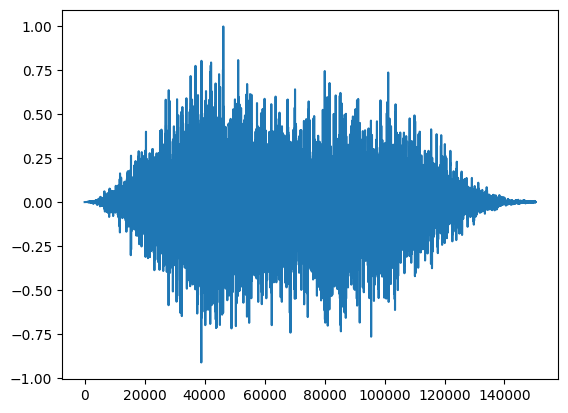

In [ ]:
plt.plot(sound / max(sound))

In [ ]:
from IPython.display import Audio
from scipy.io.wavfile import write

write('../assets/Audio/Output/test.wav', rate=48000, data=sound / max(sound))

In [ ]:
Audio('../assets/Audio/Output/test.wav', rate=48000)

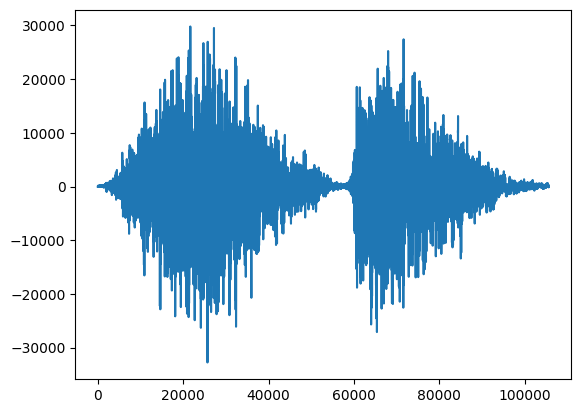

In [ ]:
plt.plot(variant_audio)

In [ ]:
from scipy.signal import spectrogram

f, t, Sxx = spectrogram(variant_audio, fs)

plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

NameError: name 'variant_audio' is not defined

In [ ]:
spikes[0]

array([  843,  6723,  9497, 14938, 16106, 17070, 19421, 20070, 23285,
       25257, 32528, 32988, 33709, 37597, 44755], dtype=int64)

In [ ]:
def sample_deaths(days=7, **kwargs):
    return np.vstack([sample_daily_deaths(**kwargs) for i in range(days)])

In [ ]:
params = {
    "x": x,
    "y": y,
    "n_deaths": n_deaths
}

deaths = sample_deaths(days=8, **params)

In [ ]:
scale = 15
dx, dy = deaths.shape
dx

img = cv.resize(deaths*255, (dy*scale, dx*scale), interpolation=cv.INTER_NEAREST)

cv.imshow("", img)
cv.waitKey(0)

ValueError: not enough values to unpack (expected 2, got 1)